# Taxi Travel Data Analysis

In this demo, we will be doing some demos on temporal feature engineering with the Kaggle Dataset

### Loading libraries, datasets

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import ast

In [2]:
# These are all of the files you are given
df_tr = pd.read_csv("train.csv")

In [3]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [4]:
df_tr = df_tr[df_tr['MISSING_DATA'] == False]


In [5]:
df_tr = df_tr.drop('TAXI_ID', axis=1)
df_tr = df_tr.drop('TRIP_ID', axis=1)

In [6]:
metadata = 'metaData_taxistandsID_name_GPSlocation.csv'
csv_df = pd.read_csv(metadata, sep=',')

merged_df = pd.merge(df_tr, csv_df, left_on='ORIGIN_STAND', right_on='ID', how='left')
# Drop unnecessary columns
merged_df.drop(['Descricao'], axis=1, inplace=True)
merged_df.drop(['ID'], axis=1, inplace=True)

# Display the merged DataFrame
print(merged_df.head())

  CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TIMESTAMP DAY_TYPE  MISSING_DATA  \
0         C          NaN           NaN  1372636858        A         False   
1         B          NaN           7.0  1372637303        A         False   
2         C          NaN           NaN  1372636951        A         False   
3         C          NaN           NaN  1372636854        A         False   
4         C          NaN           NaN  1372637091        A         False   

                                            POLYLINE       Latitude  Longitude  
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...            NaN        NaN  
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...  41.1599801853  -8.641984  
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...            NaN        NaN  
3  [[-8.574678,41.151951],[-8.574705,41.151942],[...            NaN        NaN  
4  [[-8.645994,41.18049],[-8.645949,41.180517],[-...            NaN        NaN  


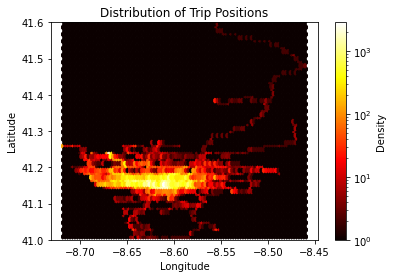

In [7]:
polyline_data = merged_df["POLYLINE"]
# Extract latitude and longitude values from the polyline_data
latitudes = []
longitudes = []
for polyline in polyline_data[0:2000]:

    if len(polyline) > 0:
        for point in eval(polyline):
            latitudes.append(point[1])
            longitudes.append(point[0])

# Create a DataFrame for the latitudes and longitudes
df = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes})

# Create a heatmap plot
plt.hexbin(df["Longitude"], df["Latitude"], gridsize=100, cmap="hot", bins="log")
plt.colorbar(label="Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of Trip Positions")
plt.ylim(41.0, 41.6)
plt.show()

### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [8]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
merged_df["LEN"] = merged_df["POLYLINE"].apply(polyline_to_trip_duration)

In [9]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
merged_df[["YR", "MON", "DAY", "HR", "WK"]] = merged_df[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [10]:
merged_df = merged_df.drop('POLYLINE', axis=1)
merged_df = merged_df.drop('TIMESTAMP', axis=1)
merged_df = merged_df.drop('YR', axis=1)
merged_df = merged_df.drop('ORIGIN_CALL', axis=1)
merged_df = merged_df.drop('MISSING_DATA', axis=1)
merged_df.head()

,CALL_TYPE,ORIGIN_STAND,DAY_TYPE,Latitude,Longitude,LEN,MON,DAY,HR,WK
0,C,NaN,A,NaN,NaN,330,7,1,0,0
1,B,7.0,A,41.1599801853,-8.641984,270,7,1,0,0
2,C,NaN,A,NaN,NaN,960,7,1,0,0
3,C,NaN,A,NaN,NaN,630,7,1,0,0
4,C,NaN,A,NaN,NaN,420,7,1,0,0


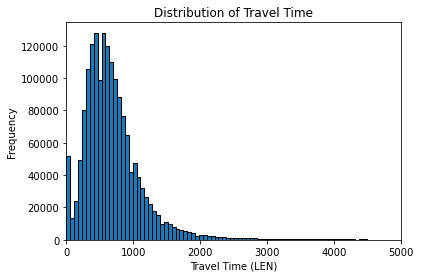

In [11]:
data = merged_df['LEN'].dropna()

# Plotting the histogram
plt.hist(data, bins=1000, edgecolor='black')

# Adding labels and title
plt.xlabel('Travel Time (LEN)')
plt.ylabel('Frequency')
plt.title('Distribution of Travel Time')
plt.xlim(0, 5000)  

# Displaying the histogram
plt.show()


In [12]:
value_counts = merged_df['ORIGIN_STAND'].value_counts(dropna=False)
proportions = value_counts / value_counts.sum()

print(proportions)


NaN     0.528500
15.0    0.046906
57.0    0.029744
9.0     0.020354
33.0    0.019950
          ...   
41.0    0.000296
43.0    0.000288
8.0     0.000223
5.0     0.000031
48.0    0.000004
Name: ORIGIN_STAND, Length: 64, dtype: float64


In [13]:
test= pd.read_csv("test_public.csv")

test = pd.merge(test, csv_df, left_on='ORIGIN_STAND', right_on='ID', how='left')
# Drop unnecessary columns
test.drop(['Descricao'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

test[["YR", "MON", "DAY", "HR", "WK"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
print(test['DAY'].unique())
print(test['WK'].unique())

unique_combinations = list(zip(test['MON'], test['DAY']))
unique_combinations = pd.unique(unique_combinations)
print(unique_combinations)


[14 30  6  1 21]
[3 1 0 5 6]
[(8, 14) (9, 30) (10, 6) (11, 1) (12, 21)]


In [14]:
test = test.drop('YR', axis=1)
test = test.drop('TRIP_ID', axis=1)
test = test.drop('TIMESTAMP', axis=1)
test = test.drop('TAXI_ID', axis=1)
test = test.drop('ORIGIN_CALL', axis=1)
test = test.drop('MISSING_DATA', axis=1)


In [15]:
merged_df['Latitude'] = pd.to_numeric(merged_df['Latitude'], errors='coerce')
merged_df['Longitude'] = pd.to_numeric(merged_df['Longitude'], errors='coerce')
#merged_df = merged_df.dropna()
#merged_df = merged_df.fillna(0)

merged_df['ORIGIN_STAND'] = merged_df['ORIGIN_STAND'].fillna(merged_df['ORIGIN_STAND'].median())
merged_df['Latitude'] = merged_df['Latitude'].fillna(merged_df['Latitude'].median())
merged_df['Longitude'] = merged_df['Longitude'].fillna(merged_df['Longitude'].median())

X = merged_df.drop('LEN', axis=1)
y = merged_df['LEN']

X_encoded = pd.get_dummies(X)
#X_encoded = X_encoded.fillna(0)
X_encoded.isna().sum()

ORIGIN_STAND    0
Latitude        0
Longitude       0
MON             0
DAY             0
HR              0
WK              0
CALL_TYPE_A     0
CALL_TYPE_B     0
CALL_TYPE_C     0
DAY_TYPE_A      0
dtype: int64

In [16]:
# Make predictions on the test set
test['Latitude'] = pd.to_numeric(test['Latitude'], errors='coerce')
test['Longitude'] = pd.to_numeric(test['Longitude'], errors='coerce')

test_encoded = pd.get_dummies(test)
test_encoded.isna().sum()

ORIGIN_STAND    197
Latitude        197
Longitude       197
MON               0
DAY               0
HR                0
WK                0
CALL_TYPE_A       0
CALL_TYPE_B       0
CALL_TYPE_C       0
DAY_TYPE_A        0
dtype: int64

In [17]:
test_encoded['ORIGIN_STAND'] = test_encoded['ORIGIN_STAND'].fillna(test_encoded['ORIGIN_STAND'].median())
test_encoded['Latitude'] = test_encoded['Latitude'].fillna(test_encoded['Latitude'].median())
test_encoded['Longitude'] = test_encoded['Longitude'].fillna(test_encoded['Longitude'].median())

In [18]:
test_encoded.isna().sum()

ORIGIN_STAND    0
Latitude        0
Longitude       0
MON             0
DAY             0
HR              0
WK              0
CALL_TYPE_A     0
CALL_TYPE_B     0
CALL_TYPE_C     0
DAY_TYPE_A      0
dtype: int64

In [19]:
test_encoded

,ORIGIN_STAND,Latitude,Longitude,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,DAY_TYPE_A
0,15.0,41.148628,-8.585877,8,14,17,3,0,1,0,1
1,57.0,41.145719,-8.610707,8,14,17,3,0,1,0,1
2,15.0,41.148628,-8.585877,8,14,17,3,0,1,0,1
3,53.0,41.141208,-8.614012,8,14,17,3,0,1,0,1
4,18.0,41.148321,-8.619603,8,14,17,3,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
315,23.0,41.149310,-8.610707,12,21,14,6,1,0,0,1
316,53.0,41.141208,-8.614012,12,21,14,6,0,1,0,1
317,23.0,41.149310,-8.610707,12,21,14,6,0,0,1,1
318,23.0,41.149310,-8.610707,12,21,14,6,1,0,0,1


### Linear regression

In [20]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 477964.03797780647


In [25]:
final_y = model.predict(test_encoded)
final_y[:5]

array([712.36931348, 665.19537958, 712.36931348, 674.98509362,
       702.16505409])

In [26]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = final_y

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred2.csv", index=None)
df_sample

,TRIP_ID,TRAVEL_TIME
0,T1,712.369313
1,T2,665.195380
2,T3,712.369313
3,T4,674.985094
4,T5,702.165054
...,...,...
315,T323,715.943409
316,T324,618.336020
317,T325,753.653297
318,T326,715.943409


### Fully connected neural network

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [29]:
# Move the data to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)


cuda


In [30]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = F.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)
        return x

100%|██████████| 760/760 [00:02<00:00, 267.07it/s]


Epoch 1/10, Loss: 951785.6846


100%|██████████| 760/760 [00:03<00:00, 245.38it/s]


Epoch 2/10, Loss: 838079.6275


100%|██████████| 760/760 [00:02<00:00, 265.40it/s]


Epoch 3/10, Loss: 686909.4953


100%|██████████| 760/760 [00:02<00:00, 265.09it/s]


Epoch 4/10, Loss: 555611.4797


100%|██████████| 760/760 [00:03<00:00, 237.70it/s]


Epoch 5/10, Loss: 479348.2341


100%|██████████| 760/760 [00:02<00:00, 267.67it/s]


Epoch 6/10, Loss: 452808.9319


100%|██████████| 760/760 [00:02<00:00, 260.69it/s]


Epoch 7/10, Loss: 448381.6156


100%|██████████| 760/760 [00:02<00:00, 268.60it/s]


Epoch 8/10, Loss: 448007.2721


100%|██████████| 760/760 [00:02<00:00, 267.72it/s]


Epoch 9/10, Loss: 447885.7429


100%|██████████| 760/760 [00:02<00:00, 267.59it/s]


Epoch 10/10, Loss: 447833.4734


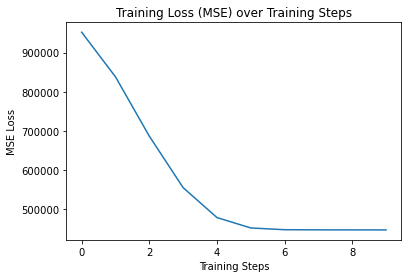

Test Loss: 465226.65625


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

indv_losses = []
# Create an instance of the neural network model
input_size = X_train_tensor.shape[1]
model = NeuralNetwork(input_size)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
batch_size = 1800
num_batches = X_train_tensor.shape[0] // batch_size

train_losses = []  # To store training losses

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(range(num_batches)):
        start = batch * batch_size
        end = start + batch_size

        inputs = X_train_tensor[start:end]
        labels = y_train_tensor[start:end]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        indv_losses.append(loss.item())
        running_loss += loss.item()

    average_loss = running_loss / num_batches
    train_losses.append(average_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}')

# Visualize the training loss over training steps
plt.plot(train_losses)
plt.xlabel('Training Steps')
plt.ylabel('MSE Loss')
plt.title('Training Loss (MSE) over Training Steps')
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs.squeeze(), y_test_tensor)
print('Test Loss:', loss.item())

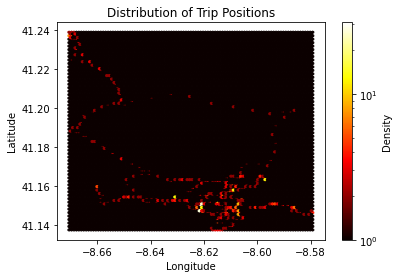

In [33]:
highest_loss_indices = np.argsort(-np.array(indv_losses))[:10]
highest_loss_indices

selected_rows = df_tr.iloc[highest_loss_indices]

polyline_data = selected_rows["POLYLINE"]
# Extract latitude and longitude values from the polyline_data
latitudes = []
longitudes = []
for polyline in polyline_data:

    if len(polyline) > 0:
        for point in eval(polyline):
            latitudes.append(point[1])
            longitudes.append(point[0])

# Create a DataFrame for the latitudes and longitudes
df = pd.DataFrame({"Latitude": latitudes, "Longitude": longitudes})

# Create a heatmap plot
plt.hexbin(df["Longitude"], df["Latitude"], gridsize=100, cmap="hot", bins="log")
plt.colorbar(label="Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribution of Trip Positions")
plt.show()

In [34]:
# Sample submission file that is given on kaggle
df_sample_nn = pd.read_csv("sampleSubmission.csv")

val = scaler.fit_transform(test_encoded)
x_val = torch.tensor(val, dtype=torch.float32)
x_val = x_val.to(device)

# Move the model to the GPU
model = model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Turn off gradient calculation
with torch.no_grad():
    # Make predictions with the model on the GPU
    predictions = model(x_val)

# Move the predictions back to the CPU
predictions = predictions.cpu()

# Convert the predictions to a numpy array
predictions = predictions.numpy()

# Assign the predictions to the "TRAVEL_TIME" column
df_sample_nn["TRAVEL_TIME"] = predictions
# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample_nn.to_csv("my_pred2.csv", index=None)
df_sample_nn

,TRIP_ID,TRAVEL_TIME
0,T1,902.948792
1,T2,929.104492
2,T3,902.948792
3,T4,941.518066
4,T5,933.095154
...,...,...
315,T323,731.973938
316,T324,772.987976
317,T325,748.096436
318,T326,731.973938


### LSTM

In [36]:
# Split the data into features (X) and target variable (y)
X = merged_df.drop("LEN", axis=1)
y = merged_df["LEN"].values

X= pd.get_dummies(X)
X = X.fillna(0).values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_heads = num_heads

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.MultiheadAttention(hidden_size, num_heads)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        if len(x.shape) == 2:  # Handle unbatched input
            x = x.unsqueeze(0)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out.permute(1, 0, 2)  # Reshape to (sequence_length, batch_size, hidden_size)
        attended_output, _ = self.attention(out, out, out)
        out = self.fc(attended_output[:, -1, :])  # Take the last timestep output and pass it through the fully connected layer
        return out

In [38]:
# Set the hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
num_heads = 4
num_epochs = 10
batch_size = 320
learning_rate = 1e-5

# Create an instance of the LSTM model
model = LSTMModel(input_size, hidden_size, num_layers, num_heads)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_batches = len(X_train) // batch_size

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(range(num_batches)):
        start = batch * batch_size
        end = start + batch_size

        inputs = X_train[start:end].to(device)
        labels = y_train[start:end].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / num_batches
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}")

100%|██████████| 4276/4276 [00:44<00:00, 95.41it/s] 


Epoch 1/10, Loss: 904526.9984


100%|██████████| 4276/4276 [00:46<00:00, 92.94it/s]


Epoch 2/10, Loss: 613710.6984


100%|██████████| 4276/4276 [00:45<00:00, 93.36it/s]


Epoch 3/10, Loss: 468953.6875


100%|██████████| 4276/4276 [00:45<00:00, 94.42it/s]


Epoch 4/10, Loss: 465442.5231


100%|██████████| 4276/4276 [00:46<00:00, 92.80it/s] 


Epoch 5/10, Loss: 465442.7523


100%|██████████| 4276/4276 [00:45<00:00, 93.83it/s]


Epoch 6/10, Loss: 465442.7241


100%|██████████| 4276/4276 [00:45<00:00, 94.82it/s]


Epoch 7/10, Loss: 465442.6677


100%|██████████| 4276/4276 [00:44<00:00, 95.34it/s]


Epoch 8/10, Loss: 465442.5343


100%|██████████| 4276/4276 [00:41<00:00, 103.72it/s]


Epoch 9/10, Loss: 465442.0968


100%|██████████| 4276/4276 [00:44<00:00, 95.29it/s]

Epoch 10/10, Loss: 465438.8235


In [32]:
model.eval()
test_batch_size = 32  # Adjust the batch size as needed
test_num_batches = len(X_test) // test_batch_size

with torch.no_grad():
    test_loss = 0.0

    for batch in range(test_num_batches):
        start = batch * test_batch_size
        end = start + test_batch_size

        inputs = X_test[start:end].cpu()
        labels = y_test[start:end].cpu()
        outputs = model(inputs.to(device))
        batch_loss = criterion(outputs.squeeze(), labels.to(device))
        test_loss += batch_loss.item()

    average_test_loss = test_loss / test_num_batches

print(f"Test Loss: {average_test_loss:.4f}")

Test Loss: 486031.4773


In [33]:
# Sample submission file that is given on kaggle
df_sample_nn = pd.read_csv("sampleSubmission.csv")

val = scaler.fit_transform(test_encoded)
x_val = torch.tensor(val, dtype=torch.float32)
x_val = x_val.to(device)

# Move the model to the GPU
model = model.to(device)

# Ensure the model is in evaluation mode
model.eval()

# Turn off gradient calculation
with torch.no_grad():
    # Make predictions with the model on the GPU
    predictions = model(x_val)

# Move the predictions back to the CPU
predictions = predictions.cpu()

# Convert the predictions to a numpy array
predictions = predictions.numpy()

# Assign the predictions to the "TRAVEL_TIME" column
df_sample_nn["TRAVEL_TIME"] = predictions
# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample_nn.to_csv("my_pred3.csv", index=None)
df_sample_nn

,TRIP_ID,TRAVEL_TIME
0,T1,705.344543
1,T2,695.266235
2,T3,688.170166
3,T4,667.293213
4,T5,659.529480
...,...,...
315,T323,716.369019
316,T324,716.368835
317,T325,716.368958
318,T326,716.369019


## Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

num_iterations = 1
total_rmse = 0

for iteration in range(num_iterations):
    
    print(f'Iteration {iteration + 1}')
    
    # Create a Random Forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=iteration)

    # Train the model
    rf_regressor.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_regressor.predict(X_test)

    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    total_rmse += rmse

average_rmse = total_rmse / num_iterations
print(f"Average RMSE over {num_iterations} iterations: {average_rmse}")


Iteration 1
Average RMSE over 1 iterations: 703.1350699872451


## XGBoost

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import xgboost as xgb

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled)

# Set XGBoost parameters
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}

num_boost_round = 1000

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

In [31]:
# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE on test set: {rmse}")

RMSE on test set: 681.3100620355419


In [33]:
# Define the grid of hyperparameters to search
param_grid = {
    "eta": [0.1, 0.3, 0.5],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.8, 0.9]
}

num_boost_round = 1000

# Create the XGBoost model
xgb_model = xgb.XGBRegressor()

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=3)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Train the best model on the full training set
best_model.fit(X_train_scaled, y_train)

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE on test set: {rmse}")
print("Best parameters:", best_params)

RMSE on test set: 680.7340809471233
Best parameters: {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 7, 'subsample': 0.9}


In [39]:
# Convert 'test_encoded' to DMatrix
#dtest_encoded = xgb.DMatrix(test_encoded)

# Make predictions on the new dataset
predictions = best_model.predict(test_encoded)

# Sample submission file that is given on kaggle
df_sample_nn = pd.read_csv("sampleSubmission.csv")

# Assign the predictions to the "TRAVEL_TIME" column
df_sample_nn["TRAVEL_TIME"] = predictions
df_sample_nn.to_csv("my_pred5.csv", index=None)
df_sample_nn

,TRIP_ID,TRAVEL_TIME
0,T1,786.742676
1,T2,786.742676
2,T3,786.742676
3,T4,786.742676
4,T5,786.742676
...,...,...
315,T323,608.459229
316,T324,786.742676
317,T325,589.837769
318,T326,608.459229
